In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

In [2]:
model_data = pd.read_parquet("data/model_data.parquet")

# Proportion d'articles avec des citations

Approche :
1. On modélise le comportement attendu des journaux, sous l'hypothèse qu'ils respectent la norme de représentativité
2. On isole le pouvoir explicatif de ce modèle pour mesurer le poids de cette norme
3. On étudie les résidus pour comprendre comment le comportement des journaux s'en écarte

On utilise pour cela les résidus relatifs moyens notés $RRM$, qui indiquent la direction et l’ampleur de l’erreur de prédiction en pourcentage de la valeur réelle.

$$\text{RRM} = \frac{1}{n} \sum_{i=1}^{n} \frac{\hat{y}_i - y_i}{y_i}$$

Un $RMM$ positif indique que le modèle surestime la part d’articles contenant des citations, c’est-à-dire qu’il surestime le respect de la norme de représentativité par le journal pour l’alignement politique donné ($\hat{y}_i ≥ y_i$). Cela signifie que le journal publie moins d’articles avec des citations de cet alignement politique que ce que la norme prévoirait. Pour simplifier la lecture, les valeurs sont inversées dans les tableaux : une valeur positive signale désormais une surreprésentation, et une valeur négative une sous-représentation.

*NB1 : Les données sont mensuelles.*

***NB2 : Les Verts ne sont pour l'instant pas représentés dans les données.***

## 1. Modèle de base
Les modèles estimés sont de la forme $Y_{i} = \beta_{i}T_i$ avec :
- $Y_{i}$ est la proportion des articles intégrant des citations de la nuance politique $i$ (avec $\sum_{i=1}^{n} Y_{i} = 1$)
- $T_i$ est la proportion des voix obtenue par les candidats de la nuance politique $i$ au premier tour des précédentes élections législatives
- $\beta_{i}$ la pondération globale des résultats électoraux de la nuance politique $i$

L'hypothèse implicite est $\beta_{i} = 1$ : les nuances politiques sont représentées identiquement à leur poids électoral une fois éliminée la couverture de l'action gouvernementale, avec un comportement identique des journaux.

In [4]:
results = {}
pvalues = {}

for alignement in model_data["alignement_politique"].unique():
    subset = model_data[model_data["alignement_politique"] == alignement]

    if len(subset) >= 3:
        X = subset[["votes_share"]]
        y = subset["art_share"]

        model = sm.OLS(y, X).fit(cov_type='HC3')
        y_pred = model.predict(X)
        mean_relative_residual = ((y_pred - y) / y).mean()

        results[alignement] = {
            "r_squared": model.rsquared,
            "mean_residual": mean_relative_residual}
        pvalues[alignement] = model.pvalues.to_dict()

    else:
        results[alignement] = {
            "r_squared": None,
            "mean_residual": None}
        pvalues[alignement] = {
            "votes_share": None,
            "government": None}

In [5]:
pval_records = []

for alignement, coeffs in pvalues.items():
    for coef_name, pval in coeffs.items():
        if pval is not None and pval > 0.01:
            pval_records.append({
                "alignement": alignement,
                "coefficient": coef_name,
                "pvalue": pval})

pval_summary = pd.DataFrame(pval_records)

r2_table = pd.DataFrame.from_dict(
    {alignement: results[alignement]['r_squared'] for alignement in results},
    orient='index',
    columns=['r_squared'])

bias_table = pd.DataFrame.from_dict(
    {alignement: results[alignement]['mean_residual'] for alignement in results},
    orient='index',
    columns=['mean_residual'])

In [6]:
if len(pval_summary) == 0:
    print("No unsignificant coeffs (pval > 0.01)")
else:
    print(f"{len(pval_summary)} unsignificant coeffs (pval > 0.01)\n")
    print(pval_summary)

No unsignificant coeffs (pval > 0.01)


In [7]:
(100*r2_table).style.format("{:.2f}")

,r_squared
centredroite_droite,93.56
centregauche_gauche,89.78
extremegauche_gaucheradicale,43.40
autre,57.09
centre,85.93
extremedroite_droiteradicale,59.76


In [8]:
(-100*bias_table).style.format("{:.2f}")

,mean_residual
centredroite_droite,-4.91
centregauche_gauche,2.29
extremegauche_gaucheradicale,-20.54
autre,-31.62
centre,57.14
extremedroite_droiteradicale,-30.52


Le modèle de base fonctionne remarquablement bien pour la droite et la gauche conventionnelle, avec des $R^2$ atteignant 90 % et des résidus relatifs négligeables. Ses performances sont plus ambivalentes pour le centre, avec un $R^2$ encore élevé mais des résidus relatifs très conséquents, signifiant que cette nuance politique fait l'objet de davantage d'articles intégrant des citations que ses résultats électoraux ne le laissent prévoir. Concernant les nuances restantes, le pouvoir explicatif du modèle de base est de 1,5 à 2 fois inférieur, avec des résidus relatifs témoignant d'une sous-représentation dans la presse comparativement à leur poids électoral.

## 2. Modèle de base + participation au gouvernement
Les modèles estimés sont de la forme $Y_{i} = \alpha_i G_i + \beta_{i}T_i$ avec :
- $Y_{i}$ est la proportion des articles intégrant des citations de la nuance politique $i$ (avec $\sum_{i=1}^{n} Y_{i} = 1$)
- $\alpha_i$ la prime que les journaux accordent à la nuance politique $i$ lorsqu'elle est au pouvoir, sous la forme d'une fraction fixe des articles intégrant des citations
- $G_i$ est une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$
- $\beta_{i}$ la pondération globale des résultats électoraux de la nuance politique $i$
- $T_i$ est la proportion des voix obtenue par les candidats de la nuance politique $i$ au premier tour des précédentes élections législatives

L'hypothèse implicite est $\alpha_i = \alpha, \beta_{i} = \beta, \beta = 1 - \alpha$ : les nuances politiques sont représentées identiquement à leur poids électoral une fois éliminée la couverture de l'action gouvernementale.

*NB : il serait intéressant de contraindre $\alpha_i = \alpha$, mais cela impliquerait de réécrire totalement le code pour n'estimer plus qu'un unique modèle pour l'ensemble des nuances politiques. Le résultat serait très lourd avec beaucoup d'indicatrices.*

In [3]:
results = {}
pvalues = {}

for alignement in model_data["alignement_politique"].unique():
    subset = model_data[model_data["alignement_politique"] == alignement]

    if len(subset) >= 3:
        X = sm.add_constant(subset[["votes_share", "government"]])
        y = subset["art_share"]

        model = sm.OLS(y, X).fit(cov_type='HC3')
        y_pred = model.predict(X)
        residuals = y_pred - y
        mean_relative_residual = ((y_pred - y) / y).mean()

        results[alignement] = {
            "r_squared": model.rsquared,
            "residuals": residuals.tolist(),
            "mean_residual": mean_relative_residual}
        pvalues[alignement] = model.pvalues.to_dict()

    else:
        results[alignement] = {
            "r_squared": None,
            "residuals": None,
            "mean_residual": None}
        pvalues[alignement] = {
            "votes_share": None,
            "government": None}

In [4]:
pval_records = []

for alignement, coeffs in pvalues.items():
    for coef_name, pval in coeffs.items():
        if pval is not None and pval > 0.01:
            pval_records.append({
                "alignement": alignement,
                "coefficient": coef_name,
                "pvalue": pval})

pval_summary = pd.DataFrame(pval_records)

r2_table = pd.DataFrame.from_dict(
    {alignement: results[alignement]['r_squared'] for alignement in results},
    orient='index',
    columns=['r_squared'])

bias_table = pd.DataFrame.from_dict(
    {alignement: results[alignement]['mean_residual'] for alignement in results},
    orient='index',
    columns=['mean_residual'])

In [5]:
if len(pval_summary) == 0:
    print("No unsignificant coeffs (pval > 0.01)")
else:
    print(f"{len(pval_summary)} unsignificant coeffs (pval > 0.01)\n")
    print(pval_summary)

2 unsignificant coeffs (pval > 0.01)

                     alignement  coefficient    pvalue
0  extremegauche_gaucheradicale  votes_share  0.529319
1                         autre  votes_share  0.018748


In [6]:
(100*r2_table).style.format("{:.4f}")

,r_squared
centredroite_droite,75.5390
centregauche_gauche,62.7987
extremegauche_gaucheradicale,0.0272
autre,0.3824
centre,84.1311
extremedroite_droiteradicale,4.7135


In [13]:
(-100*bias_table).style.format("{:.4f}")

,mean_residual
centredroite_droite,1.4427
centregauche_gauche,7.4622
extremegauche_gaucheradicale,-20.5379
autre,-31.6246
centre,22.8832
extremedroite_droiteradicale,-30.5202


L'ajout de la participation gouvernementale modifie peu les performances du modèle de base. Cela n'est pas surprenant puisqu'elle concerne seulement les nuances politiques conventionnelles, pour lesquelles ce modèle fonctionne déjà très bien. Son intégration entraîne toutefois une division par presque 3 des résidus relatifs concernant le centre, permettant de les ramener au niveau de l'extrême gauche.

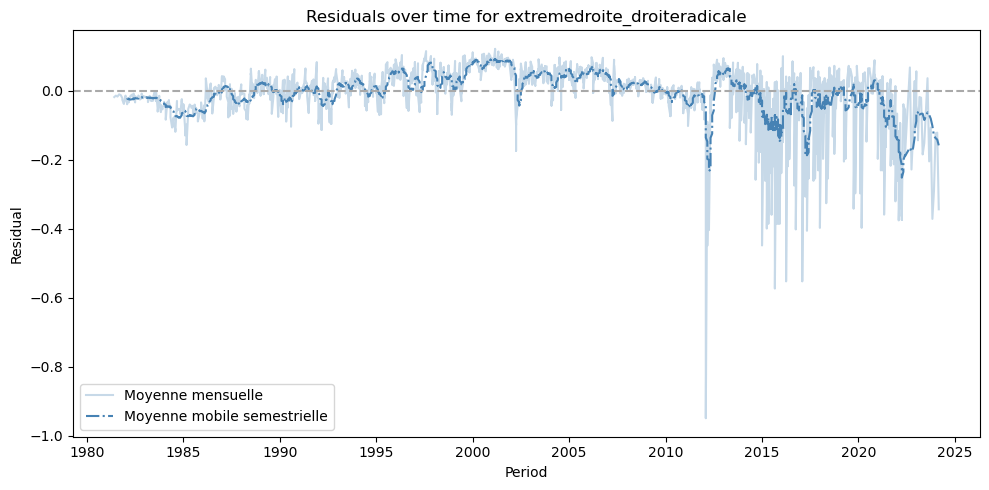

In [14]:
alignment = 'extremedroite_droiteradicale'
residuals = pd.Series(results[alignment]['residuals'])
residuals_ma = residuals.rolling(window=12).mean()
periods = (model_data[model_data['alignement_politique'] == alignment]['month']).dt.to_timestamp()

plt.figure(figsize=(10, 5))

plt.plot(periods, residuals, marker='', linestyle='-', color='steelblue', label='Moyenne mensuelle', alpha=0.3)
plt.plot(periods, residuals_ma, marker='', linestyle='dashdot', color='steelblue', label='Moyenne mobile semestrielle')
plt.axhline(0, color='darkgray', linestyle='--')

plt.title(f"Residuals over time for {alignment}")
plt.xlabel("Period")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Modèle de base + participation au gouvernement + différences entre journaux
Les modèles estimés sont de la forme $Y_{ij} = \alpha_{ij}G_i + \beta_{ij}T_i$ avec :
- $Y_{ij}$ est la proportion des articles intégrant des citations de la nuance politique $i$ dans le journal $j$ (avec $\sum_{i=1}^{n} Y_{ij} = 1$)
- $\alpha_{ij}$ la prime que le journal $j$ accorde à la nuance politique $i$ lorsqu'elle est au pouvoir, sous la forme d'une fraction fixe des articles intégrant des citations
- $G_i$ est une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$
- $\beta_{ij}$ la pondération des résultats électoraux de la nuance politique $i$ par le journal $j$
- $T_i$ est la proportion des voix obtenue par les candidats de la nuance politique $i$ au premier tour des précédentes élections législatives

L'hypothèse implicite est $\alpha_{ij} = \alpha_j, \beta_{ij} = \beta_j, \beta_j = 1 - \alpha_j$ : les nuances politiques sont représentées identiquement à leur poids électoral une fois éliminée la couverture de l'action gouvernementale. L'importance de celle-ci est la seule différence entre les journaux.

*NB : comme précédemment, il serait intéressant d'imposer $\alpha_{ij} = \alpha_{j}$ mais cela n'est pas simple.*

In [15]:
results = {}
pvalues = {}

for alignement in model_data["alignement_politique"].unique():
    results[alignement] = {}
    pvalues[alignement] = {}
    
    for journal in model_data["journal"].unique():
        subset = model_data[
            (model_data["alignement_politique"] == alignement) &
            (model_data["journal"] == journal)]
        
        if len(subset) >= 3:
            X = subset[["votes_share", "government"]]
            y = subset["art_share"]
            
            model = sm.OLS(y, X).fit(cov_type='HC3')
            y_pred = model.predict(X)
            mean_relative_residual = ((y_pred - y) / y).mean()
            
            results[alignement][journal] = {
                "r_squared": model.rsquared,
                "mean_residual": mean_relative_residual}
            
            pvalues[alignement][journal] = model.pvalues.to_dict()
            
        else:
            results[alignement][journal] = {
                "r_squared": None,
                "mean_residual": None}
            pvalues[alignement][journal] = {
                "votes_share": None,
                "government": None}

In [16]:
pval_records = []

for alignement, journals in pvalues.items():
    for journal, coeffs in journals.items():
        for coef_name, pval in coeffs.items():
            if pval is not None and pval > 0.01:
                pval_records.append({
                    "alignement": alignement,
                    "journal": journal,
                    "coefficient": coef_name,
                    "pvalue": pval})

pval_summary = pd.DataFrame(pval_records)

r2_table = pd.DataFrame({
    alignement: {journal: results[alignement][journal]['r_squared'] for journal in results[alignement]}
    for alignement in results}).sort_index().T

bias_table = pd.DataFrame({
    alignement: {journal: results[alignement][journal]['mean_residual'] for journal in results[alignement]}
    for alignement in results}).sort_index().T

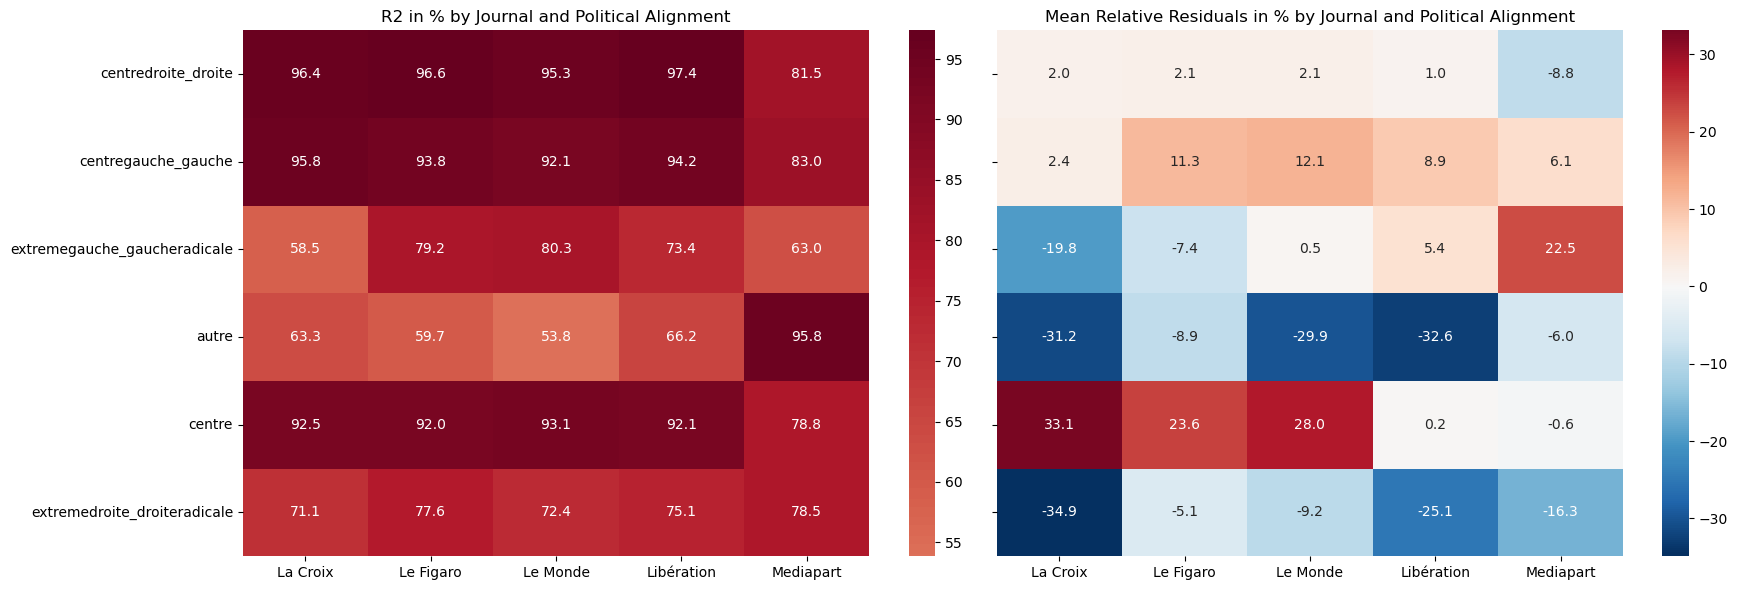

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.heatmap(100*r2_table, annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[0])
axes[0].set_title("R2 in % by Journal and Political Alignment")

sns.heatmap(-100*bias_table, annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[1])
axes[1].set_title("Mean Relative Residuals in % by Journal and Political Alignment")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [18]:
if len(pval_summary) == 0:
    print("No unsignificant coeffs (pval > 0.01)")
else:
    print(f"{len(pval_summary)} unsignificant coeffs (pval > 0.01):\n")
    print(pval_summary)

1 unsignificant coeffs (pval > 0.01):

            alignement    journal coefficient    pvalue
0  centredroite_droite  Mediapart  government  0.683683


Concernant les **nuances politiques conventionnelles**, tous les journaux, à l’exception de *Médiapart*, respectent étroitement la norme de représentativité, avec des valeurs de $R^2$ dépassant 90 %. *Médiapart* suit cette norme dans une moindre mesure, avec des valeurs de $R^2$ allant de 64 % à 83,5 %. Toutefois, le centre est nettement surreprésenté dans *La Croix*, *Le Figaro* et *Le Monde*, mais pas dans *Libération* ni *Médiapart*.

Concernant l’**extrême droite**, tous les journaux reflètent sa part de vote de manière similaire, avec des valeurs de $R^2$ situées entre 70 % et 80 %. Elle tend également à être sous-représentée, en particulier par *Médiapart*, *Libération* et, plus encore, *La Croix*.

Concernant l’**extrême gauche**, la norme de représentativité semble un peu moins cohérente, avec des valeurs de $R^2$ allant de 58 % à 80 %. Cette nuance politique tend à être sous-représentée par *La Croix* et surreprésentée par *Médiapart*, tandis que les autres journaux semblent plus neutres.

Ces résultats sont cohérents avec l’hypothèse de différences dans les lignes éditoriales entre les journaux, mais pas avec l’idée d’un traitement favorable de l’extrême droite.

## 4. Modèle de base + participation au gouvernement + différence entre les journaux + effet des périodes
Il s'agit maintenant d'étudier plus directement l'hypothèse d'une légitimation de l'extrême droite par la presse écrite nationale. La méthode la plus simple est d'estimer les modèles précédents pour 2 périodes, en écrivant $Y_{ijt} = \alpha_{ijt}G_it + \beta_{ijt}T_{it}$ : on s'attend à observer un déclin des $R^2$ associé à une augmentation des $RRM$ pour cette nuance politique.

On retient 2012 comme charnière, avec l'idée que...
- La période précédente est encore marquée par le jeu fonctionnement traditionnel du système politique, avec une domination persistante de la droite et de la gauche de gouvernement, malgré leurs recompositions.
- La période suivante est caractérisée par l'effondrement de ce système, avec l'essort du centre et des extrêmes.

In [19]:
results = {}
pvalues = {}
cutoff = pd.Period('2012-06', freq='M')

for period_label, period_filter in {
    'pre2012': model_data["month"] < cutoff,
    'post2012': model_data["month"] >= cutoff
}.items():
    
    results[period_label] = {}
    pvalues[period_label] = {}

    period_data = model_data[period_filter]

    for alignement in period_data["alignement_politique"].unique():
        results[period_label][alignement] = {}
        pvalues[period_label][alignement] = {}

        for journal in period_data["journal"].unique():
            subset = period_data[
                (period_data["alignement_politique"] == alignement) &
                (period_data["journal"] == journal)]
            
            if len(subset) >= 3:
                X = subset[["votes_share", "government"]]
                y = subset["art_share"]
                
                model = sm.OLS(y, X).fit(cov_type='HC3')
                y_pred = model.predict(X)
                mean_relative_residual = ((y_pred - y) / y).mean()
                
                results[period_label][alignement][journal] = {
                    "r_squared": model.rsquared,
                    "mean_residual": mean_relative_residual}
                
                pvalues[period_label][alignement][journal] = model.pvalues.to_dict()

            else:
                results[period_label][alignement][journal] = {
                    "r_squared": None,
                    "mean_residual": None}
                pvalues[period_label][alignement][journal] = {
                    "votes_share": None,
                    "government": None}

In [20]:
pval_records = []

for period, alignements in pvalues.items():
    for alignement, journals in alignements.items():
        for journal, coeffs in journals.items():
            for coef_name, pval in coeffs.items():
                if pval is not None and pval > 0.01:
                    pval_records.append({
                        "period": period,
                        "alignement": alignement,
                        "journal": journal,
                        "coefficient": coef_name,
                        "pvalue": pval})

pval_summary = pd.DataFrame(pval_records)

r2_tables = {}
for period, alignements in results.items():
    r2_tables[period] = pd.DataFrame({
        alignement: {
            journal: results[period][alignement][journal]['r_squared']
            for journal in results[period][alignement]
        } for alignement in results[period]
    }).sort_index().T

bias_tables = {}
for period, alignements in results.items():
    bias_tables[period] = pd.DataFrame({
        alignement: {
            journal: results[period][alignement][journal]['mean_residual']
            for journal in results[period][alignement]
        } for alignement in results[period]
    }).sort_index().T

In [21]:
if len(pval_summary) == 0:
    print("No unsignificant coeffs (pval > 0.01)")
else:
    print(f"{len(pval_summary)} unsignificant coeffs (pval > 0.01):\n")
    print(pval_summary)

5 unsignificant coeffs (pval > 0.01):

     period           alignement     journal  coefficient    pvalue
0   pre2012                autre    La Croix  votes_share  0.079044
1  post2012  centregauche_gauche    La Croix   government  0.967513
2  post2012  centregauche_gauche   Le Figaro   government  0.046453
3  post2012  centregauche_gauche    Le Monde   government  0.012234
4  post2012  centregauche_gauche  Libération   government  0.037726


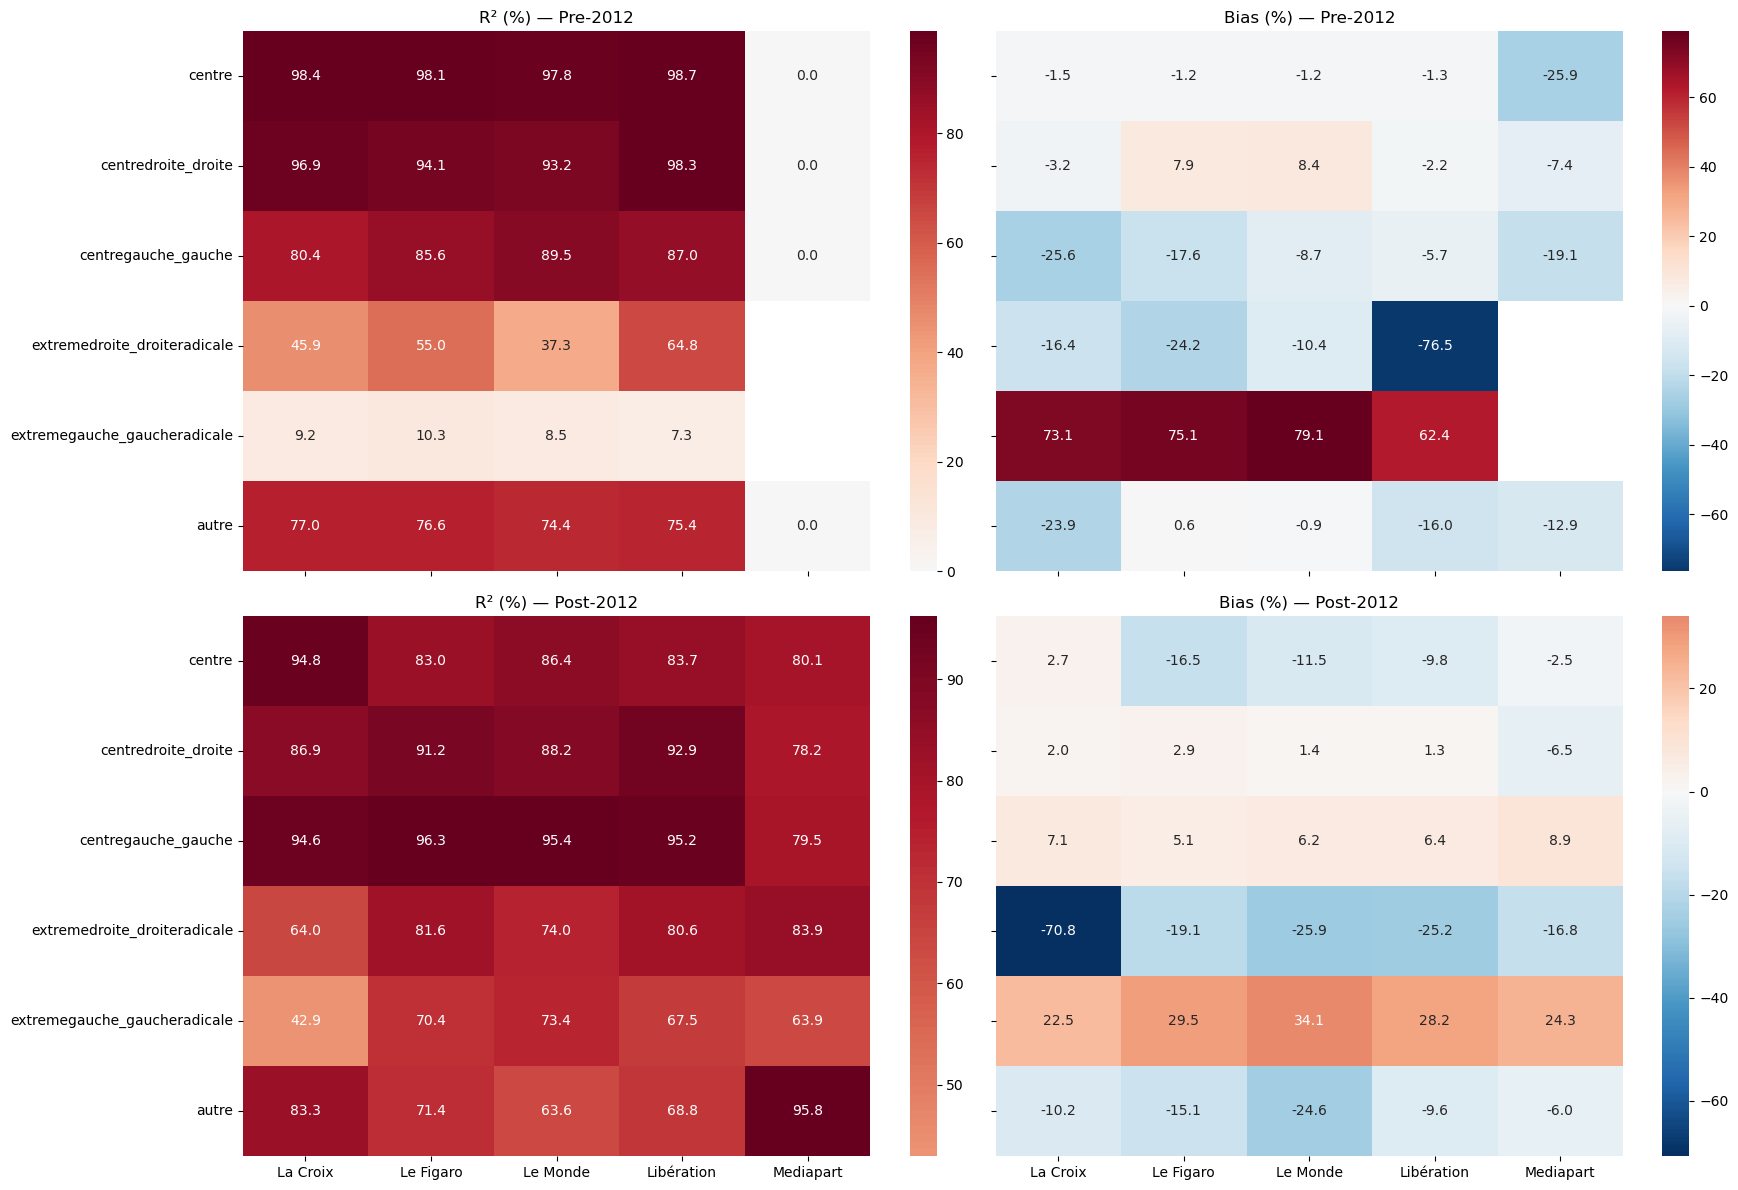

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)

sns.heatmap(100 * r2_tables["pre2012"], annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[0, 0])
axes[0, 0].set_title("R² (%) — Pre-2012")

sns.heatmap(100 * r2_tables["post2012"], annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[1, 0])
axes[1, 0].set_title("R² (%) — Post-2012")

sns.heatmap(-100 * bias_tables["pre2012"], annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[0, 1])
axes[0, 1].set_title("Bias (%) — Pre-2012")

sns.heatmap(-100 * bias_tables["post2012"], annot=True, fmt=".1f", cmap="RdBu_r", center=0, ax=axes[1, 1])
axes[1, 1].set_title("Bias (%) — Post-2012")

axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")

plt.tight_layout()
plt.show()

Très rapidement, c'est l'extrême gauche qui semble bénéficier d'un traitement de faveur plutôt que l'extrême droite !

## 5. Conclusion
Le nombre d’articles intégrant des citations pourrait en fait dépendre de la répartition des sièges à l’Assemblée nationale, qui serait mieux reflétée par les scores électoraux des partis dominants. Il est aussi possible que la couverture médiatique des extrêmes soit davantage sensible aux cycles électoraux et aux scores anticipés à l'élection présidentielle. **Dans l'immédiat, il faudrait surtout intégrer les Verts !**

On pourrait tester plus formellement des hypothèses en bootstrappant...